# AGN use case notebook

ALeRCE starter notebook for AGN science.
You will need to install psycopg2 and GPy

### Load libraries
_External dependencies:_  
psycopg2: pip install psycopg2-binary  
GPy: pip install GPy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy import coordinates
from scipy.stats import chi2
import sys

In [2]:
#!pip install psycopg2-binary
import psycopg2

In [3]:
#!pip install GPy
import GPy

In [4]:
#!pip install websocket-client
#!pip install alerce_xmatch
from alerce_xmatch import Catalog, TargetCatalog, OutputCols, crossmatch

  
### Get credentials (not in github repository)  

In [5]:
import json
credentials_file = "../alercereaduser.json"
with open(credentials_file) as jsonfile:
    params = json.load(jsonfile)["params"]

  
### Connect to DB    

In [6]:
conn = psycopg2.connect(dbname=params['dbname'], user=params['user'], host=params['host'], password=params['password'])

### Show all the available tables

In [7]:
query = "select tablename from pg_tables where schemaname='public';"
tables = pd.read_sql_query(query, conn)
tables

,tablename
0,class
1,asassn
2,crtsnorth
3,crtssouth
4,detections
5,insert_tmp
6,objects
7,probabilities
8,xmatch
9,features


### For each table, show column names and column types

In [8]:
alltabs = []
for tab in sorted(tables.tablename):
    cols = pd.DataFrame()
    query = "select column_name, data_type from information_schema.columns where table_name = '%s';" % tab
    results = pd.read_sql_query(query, conn)
    results["table"] = tab
    alltabs.append(results)
dftab = pd.concat(alltabs)
pd.options.display.max_rows = 999
display(dftab[["table", "column_name", "data_type"]])
pd.options.display.max_rows = 101

,table,column_name,data_type
0,asassn,ASAS-SN Name,text
1,asassn,Other Names,text
2,asassn,LCID,integer
3,asassn,ra,double precision
4,asassn,dec,double precision
5,asassn,Mean VMag,double precision
6,asassn,Amplitude,double precision
7,asassn,Period,double precision
8,asassn,Type,text
9,asassn,Url,text


### Query class numbers

In [9]:
query = "select * from class"
classes = pd.read_sql_query(query, conn)
classmapper = dict(zip(classes.name.tolist(), classes.id.tolist()))
classmapper

{'Other': 0, 'Ceph': 1, 'LPV': 4, 'RRL': 5, 'EB': 3, 'SNe': 6, 'DSCT': 2}

  
### Create function to plot AGN light curve  

In [10]:
def plotLC(oid, AGN_det, AGN_nondet):
    
    fig, ax = plt.subplots(figsize = (14, 7))
    labels = {1: 'g', 2: 'r'}
    colors = {1: 'g', 2: 'r'}
    for fid in [1, 2]:
        mask = AGN_det.fid == fid
        if np.sum(mask) > 0:            
            ax.errorbar(AGN_det[mask].mjd, AGN_det[mask].magpsf_corr, 
                yerr = AGN_det[mask].sigmapsf_corr, c = colors[fid], marker = 'o', label = labels[fid])
        mask = (AGN_nondet.fid == fid) & (AGN_nondet.diffmaglim > -900)
        #if np.sum(mask) > 0:            
        #    ax.scatter(AGN_nondet[mask].mjd, AGN_nondet[mask].diffmaglim, c = colors[fid], alpha = 0.5,
        #        marker = 'v', label = "lim.mag. %s" % labels[fid])
    ax.set_title(oid)
    ax.set_xlabel("MJD")
    ax.set_ylabel("Magnitude")
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])

  
### Create function to get data and plot AGN light curve

In [11]:
def getAGNdata(oid, doplot = False):
    
    # query detections
    query="select oid, ra, dec, fid, mjd, magpsf_corr, sigmapsf_corr from detections where oid='%s'" % oid
    AGN_det = pd.read_sql_query(query, conn)
    AGN_det.sort_values(by=['mjd'], inplace=True)
        
    # query non detections
    query="select oid, fid, mjd, diffmaglim from non_detections where oid='%s'" % oid
    AGN_nondet = pd.read_sql_query(query, conn)
    AGN_nondet.sort_values(by=['mjd'], inplace=True)
            
    if doplot:
        plotLC(oid, AGN_det, AGN_nondet)
                
    # return data
    return AGN_det, AGN_nondet

### Define some variability features  

(Sanchez-Saez et al 18, 19)


The probability that the source is intrinsically variable ($P_{var}$):  

$$\chi^2=\sum_{i=1}^{N_{obs}}\frac{(x_i-\bar{x})^2}{\sigma^2_{err,i}}$$
$$P_{var}=P(\chi^2)$$ 
  
And the excess variance ($\sigma_{rms}$), which a measure of the intrinsic variability amplitude:  

$$\sigma^2_{rms}=\frac{1}{N_{obs}\bar{x}^2}\sum^{N_{obs}}_{i=1}[(x_i-\bar{x})^2-\sigma^2_{err,i}]$$

In [12]:
def var_parameters(jd,mag,err):
    """function to calculate the probability of a light curve to be variable and the excess variance"""
    
    from scipy.stats import chi2
    
    mean = np.mean(mag)
    nepochs = float(len(jd))

    #P_var
    chi = np.sum( (mag - mean)**2. / err**2. )
    P_var = chi2.cdf(chi,(nepochs-1))

    #ex_var
    a = (mag - mean)**2
    ex_var = (np.sum(a - err**2)/((nepochs * mean**2)))
    

    return [P_var,ex_var]


Damped Random Walk process (DRW):  

$$dX(t)=-\frac{1}{\tau}X(t)dt+\sigma_{DRW}\sqrt{dt}\,\epsilon(t)+b\,dt$$
  
with $\tau,\sigma_{DRW},t>0$. $\tau$ corresponds to the "relaxation time" of the process or the characteristic time for the time series to become roughly uncorrelated, and has units of days, $\sigma_{DRW}$ corresponds to the amplitude of the variability at short time-scales ($t<<\tau$), and has units of mag/day$^{1/2}$

In [13]:
def GP_DRW(t, mag, err):
    """
    Based on Matthew Graham's method to model DRW with gaussian process

    inputs:
    t: julian days array
    mag: magnitudes array
    err: error of magnitudes array

    outputs:
    sigma^2: variance of the light curve at short time scales
    tau: decorrelation time scale
    """

    # Fit GP OU model
    mag -= mag.mean()
    kern = GPy.kern.OU(1)
    m = GPy.models.GPHeteroscedasticRegression(t[:, None], mag[:, None], kern)
    m['.*het_Gauss.variance'] = abs(err ** 2.)[:, None] 
    m.het_Gauss.variance.fix() 
    m.optimize()
    pars = [m.OU.variance.values[0], m.OU.lengthscale.values[0]] # sigma^2, tau
    return pars[0], pars[1]

  
### Load external dataframe with known changing state AGNs  (CSAGNs)
From multiple refences (e.g., Graham et al. 2019; MacLeod et al. 2016)

In [14]:
# read csv
mycatdf = pd.read_csv("../example_data/CSAGN_coordinates.csv")
mycatdf.head()

# rename some columns to be compatible with xmatch service
mycatdf.rename({"RA": "ra", "DEC": "dec"}, axis="columns", inplace=True)
mycatdf.index.names=["mycat_id"]

# drop nans in ra, dec
mycatdf.dropna(subset=['ra', 'dec'], inplace=True)
mycatdf.head()

# create catalog object
mycat = Catalog(df=mycatdf, name="CSAGN")
mycat.df.shape
mycat.df.head()

,ra,dec
mycat_id,,
0,123.330417,46.146944
1,144.551250,7.727778
2,150.583750,45.157500
3,173.121250,3.958056
4,194.819583,55.251944


  
### Do crossmatch between the two catalogs
The crossmatched catalog is a catalog with the intersection, it is saved in the savedir directory (this takes ~20 s depending on internet connection speed)

In [22]:
xmatch = mycat.crossmatch(TargetCatalog.ZTF, output=OutputCols.BOTH).df

TimeoutError: [Errno 110] Connection timed out

### Get the light curves of the crossmatched sources, plot them, and compute some variability features
Selectig only those sources with z<0.2 and with more than 50 detections in ZTF

['ZTF18aauoxde' 'ZTF18acbwaas' 'ZTF18acepfmo' 'ZTF18aachhwp'
 'ZTF18aawvzwe' 'ZTF18aajkcve' 'ZTF18aawpgrb' 'ZTF18aaxlxtr'
 'ZTF18aaqmmll' 'ZTF18aactknu' 'ZTF18aaceswp' 'ZTF18aaoudgg'
 'ZTF18aasrupq' 'ZTF18aajncmt' 'ZTF18aaqdmnz' 'ZTF18abjyivn'
 'ZTF18aajarpg' 'ZTF19aascufy' 'ZTF18aacekzd' 'ZTF18aamznms'
 'ZTF18acvgore' 'ZTF19aamraau' 'ZTF18aanbpfo' 'ZTF18acezagf'
 'ZTF18aajdcdt' 'ZTF18aabpiat' 'ZTF18aaeixri' 'ZTF18abtnfmp'
 'ZTF19aalmwdr' 'ZTF19aanhosb' 'ZTF18aacozge' 'ZTF18aavohdq'
 'ZTF19aaohtue' 'ZTF19aaipqls' 'ZTF18aaxnjew' 'ZTF18aagenpf'
 'ZTF18aaqdmoa' 'ZTF18acvgwug' 'ZTF18aayiule'] 

ZTF18aaxlxtr  Pvar_g, exvar_g =  0.9545453466419664 4.570971648648799e-06
ZTF18aaxlxtr  sigma_g, tau_g =  0.016402164648900014 197.66846665928205
ZTF18aaxlxtr  Pvar_r, exvar_r =  0.7690760082421116 8.600789149693075e-08
ZTF18aaxlxtr  sigma_r, tau_r =  0.0017992186151877592 21.37887107433797
ZTF18aaqmmll  Pvar_g, exvar_g =  1.0 0.00026419688763096365
ZTF18aaqmmll  sigma_g, tau_g =  0.0985435677037222

 /home/fforster/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


ZTF18acvgore  Pvar_g, exvar_g =  0.054205100441578266 -3.9520472936793766e-05
ZTF18acvgore  sigma_g, tau_g =  4.4849302258188934e-08 0.8863819938437442
ZTF18acezagf  Pvar_g, exvar_g =  0.18730831861066594 -7.376964379845294e-06
ZTF18acezagf  sigma_g, tau_g =  2.7221724745094705e-18 0.8952956553896386
ZTF18aajdcdt  Pvar_g, exvar_g =  0.18217527154171265 -8.682846386118153e-06
ZTF18aajdcdt  sigma_g, tau_g =  7.146083251074877e-16 1.1855325684296505
ZTF18aajdcdt  Pvar_r, exvar_r =  0.028910794465031222 -1.2845975703507482e-05
ZTF18aajdcdt  sigma_r, tau_r =  4.959013603431599e-24 1.5465606636030206e-06
ZTF18aabpiat  Pvar_g, exvar_g =  1.0 0.000534515266008674
ZTF18aabpiat  sigma_g, tau_g =  0.3178424443353285 111.27357764923411
ZTF18aabpiat  Pvar_r, exvar_r =  1.0 0.0005992771907174215
ZTF18aabpiat  sigma_r, tau_r =  0.3172659895601392 119.31995631792695
ZTF18aaeixri  Pvar_g, exvar_g =  0.9999964362682584 1.2847724884565278e-05
ZTF18aaeixri  sigma_g, tau_g =  0.011002694136626757 124.88109

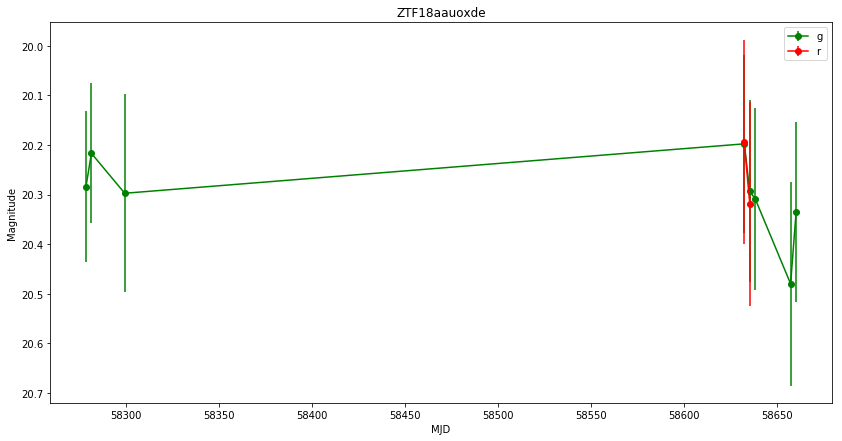

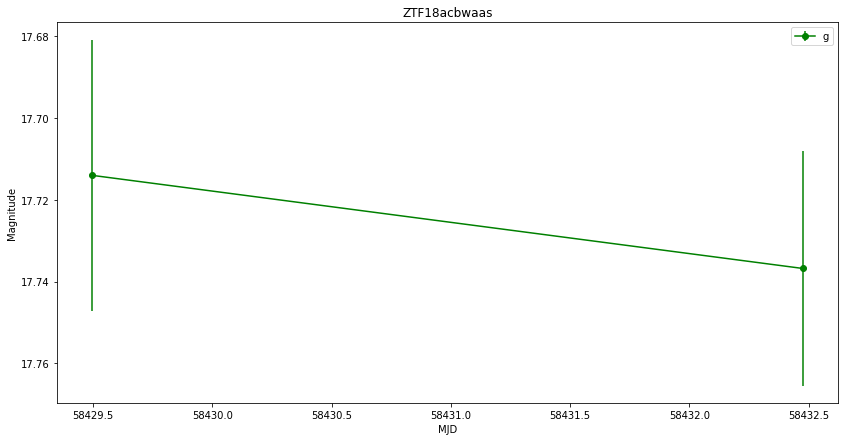

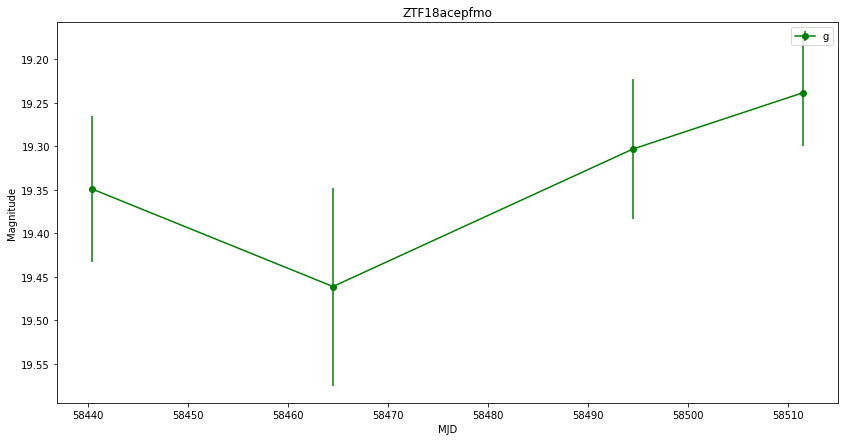

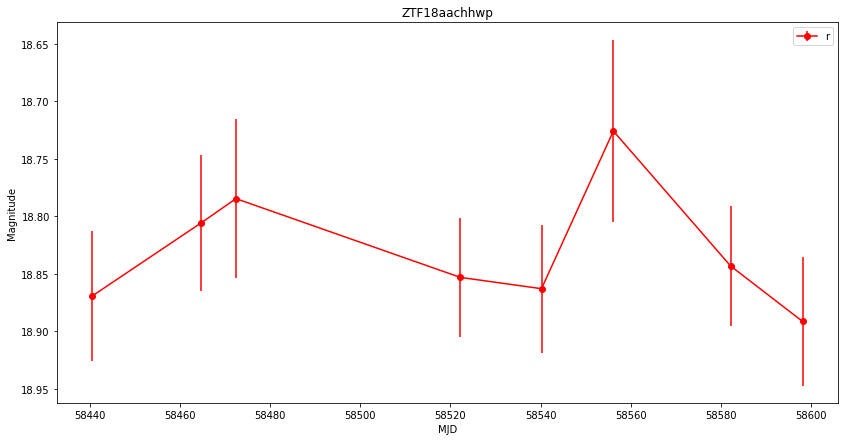

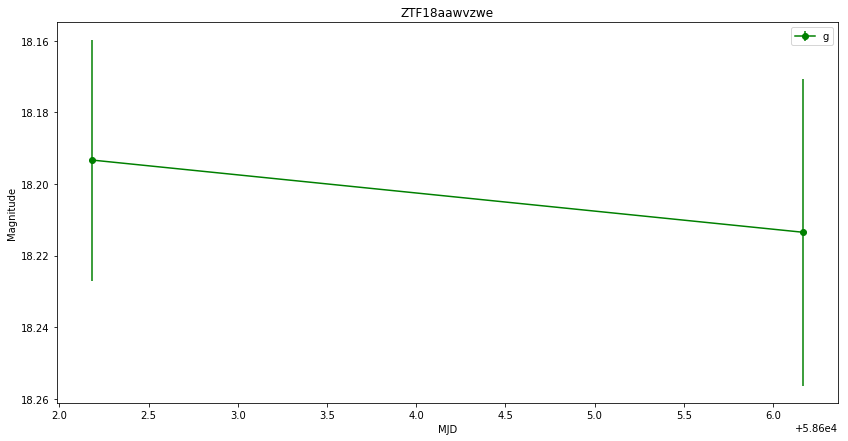

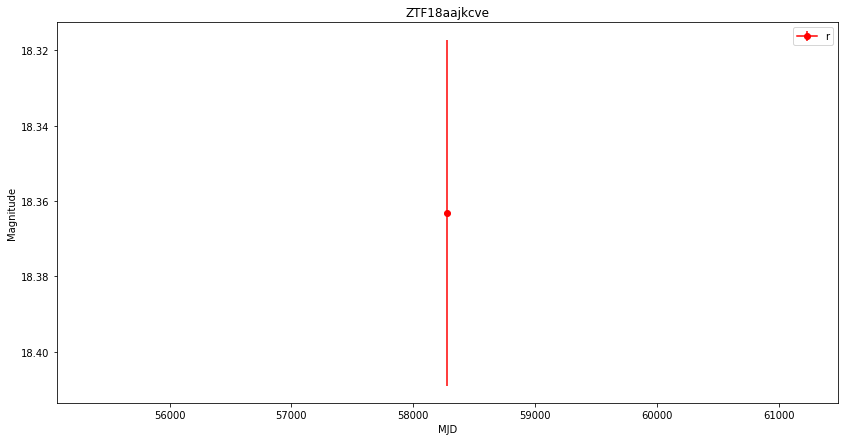

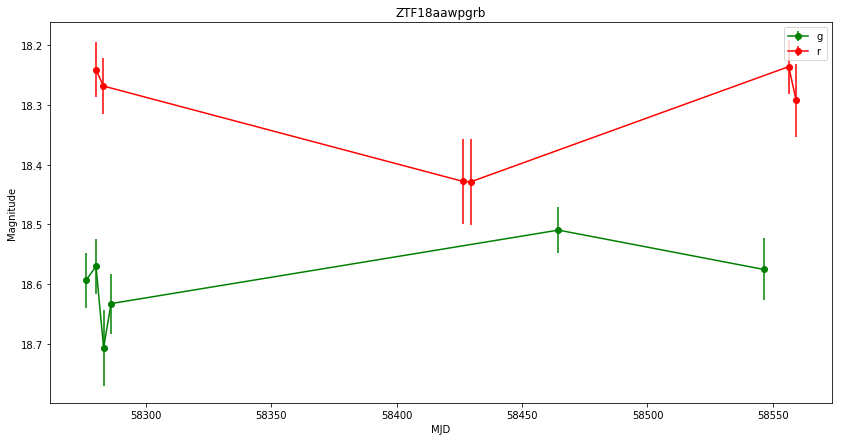

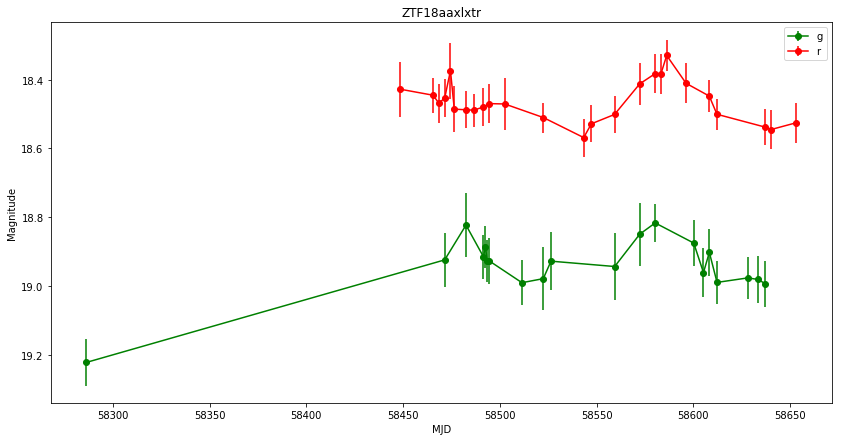

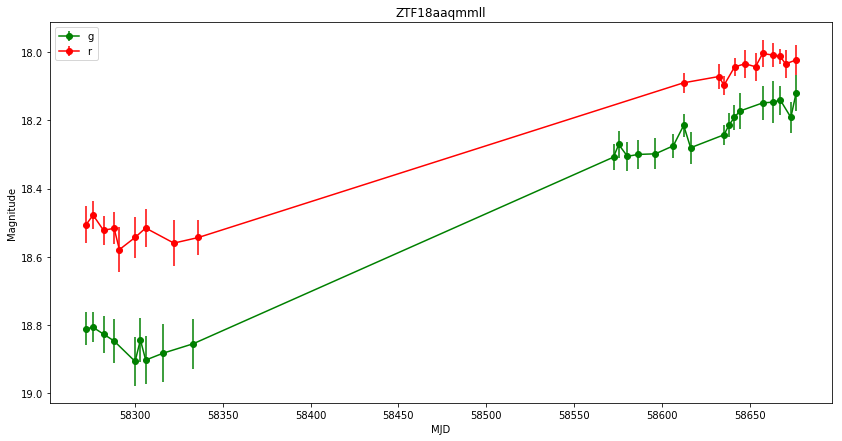

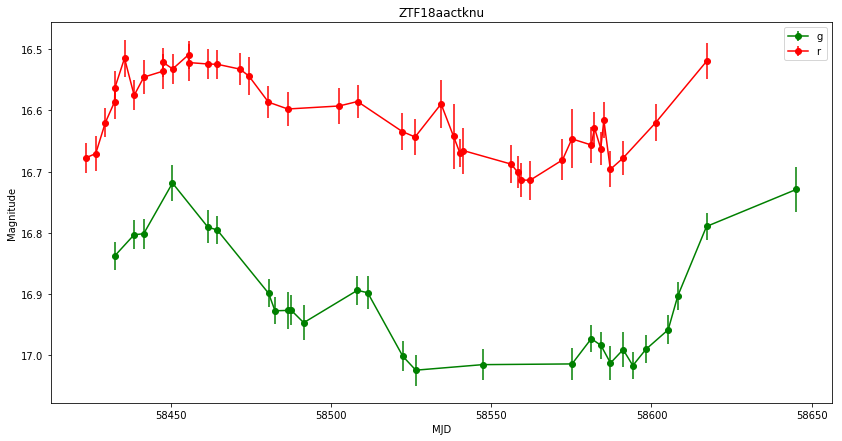

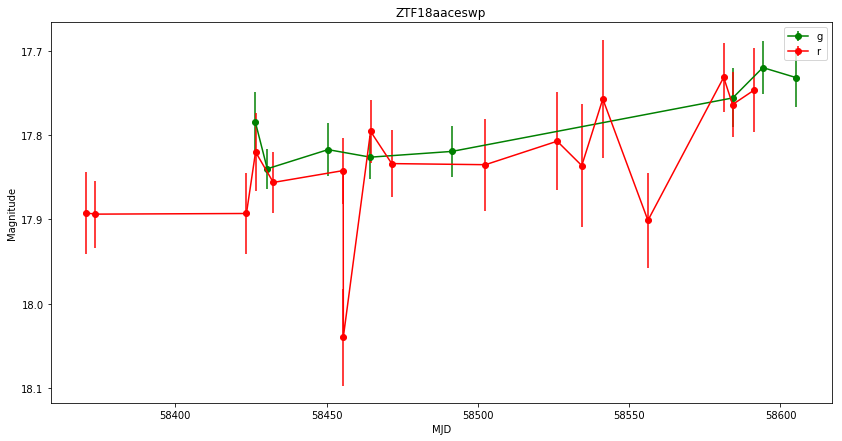

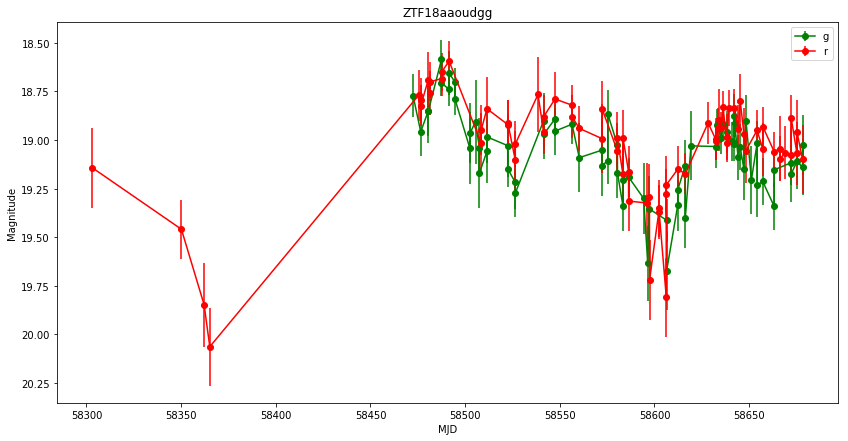

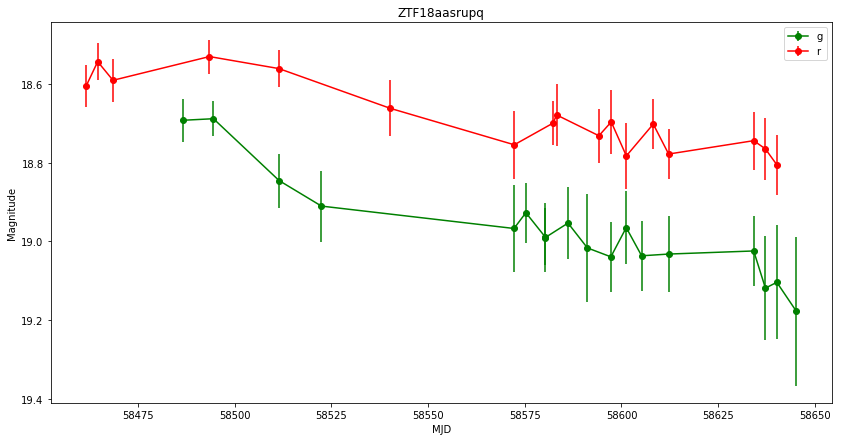

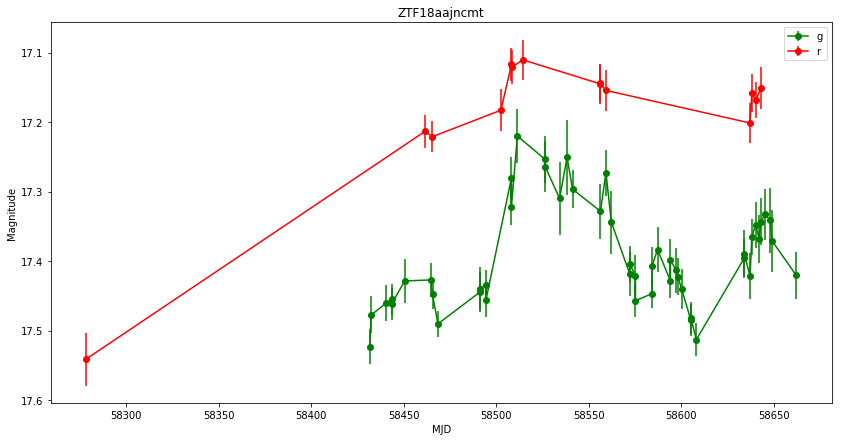

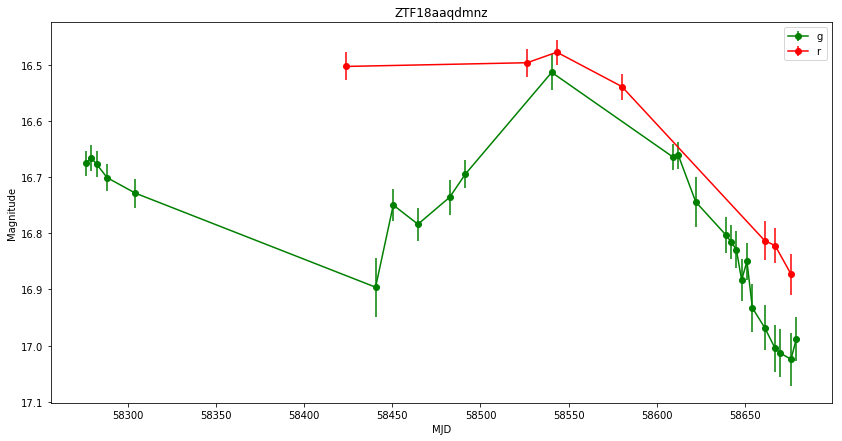

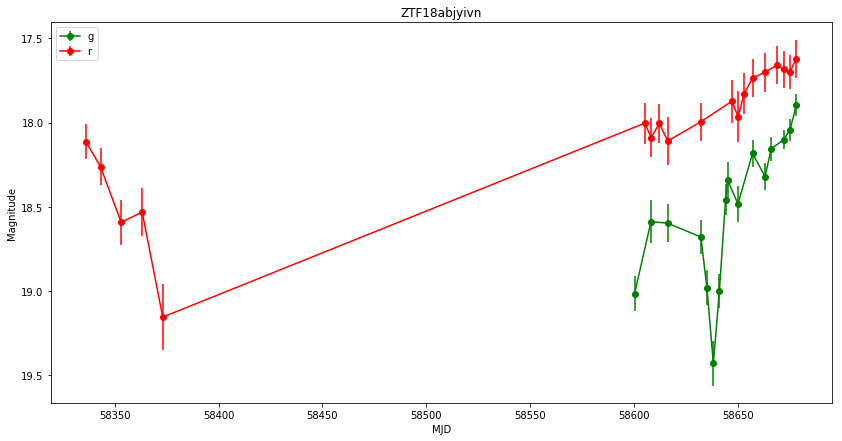

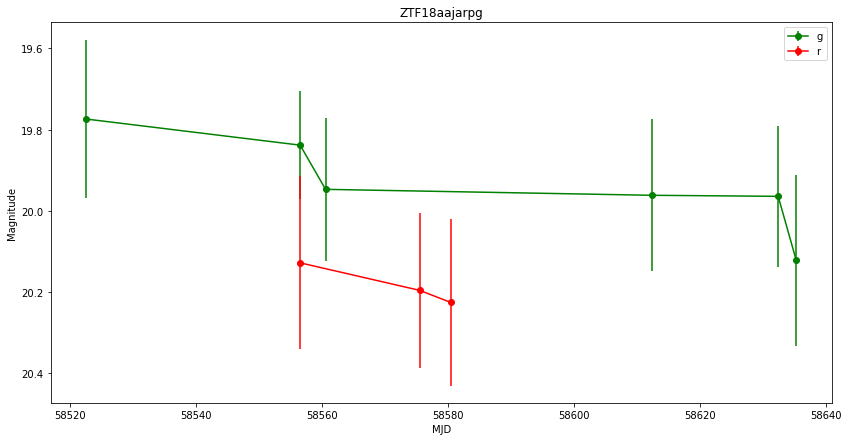

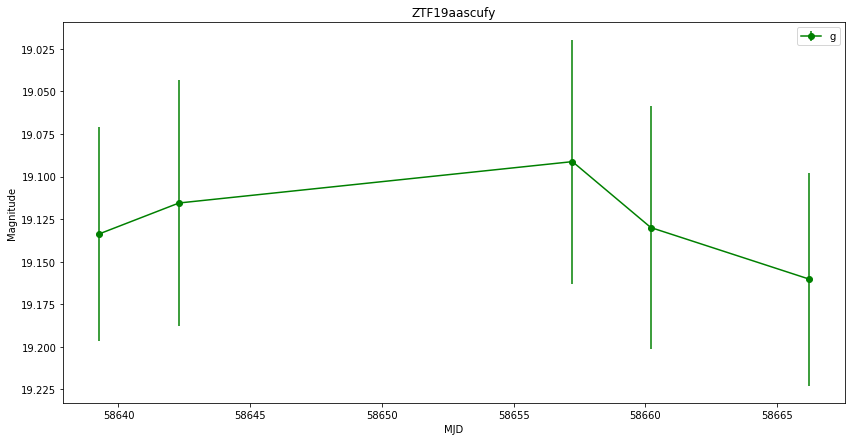

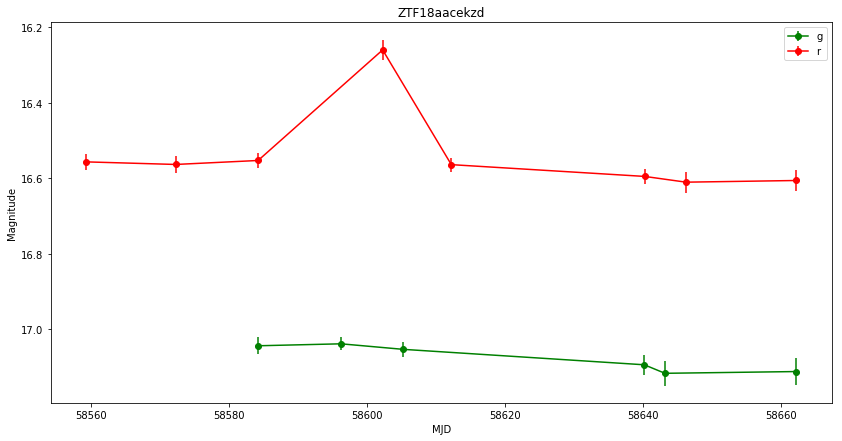

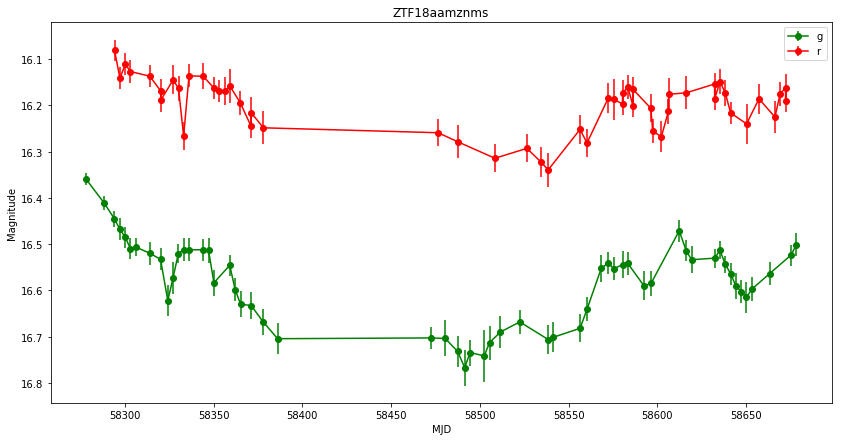

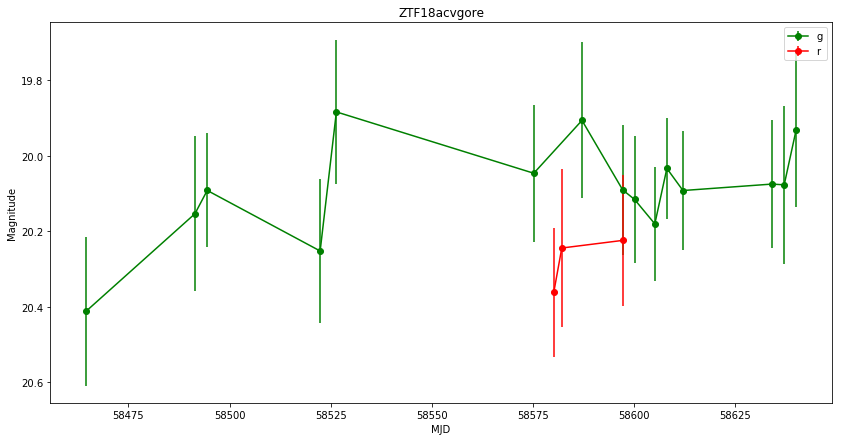

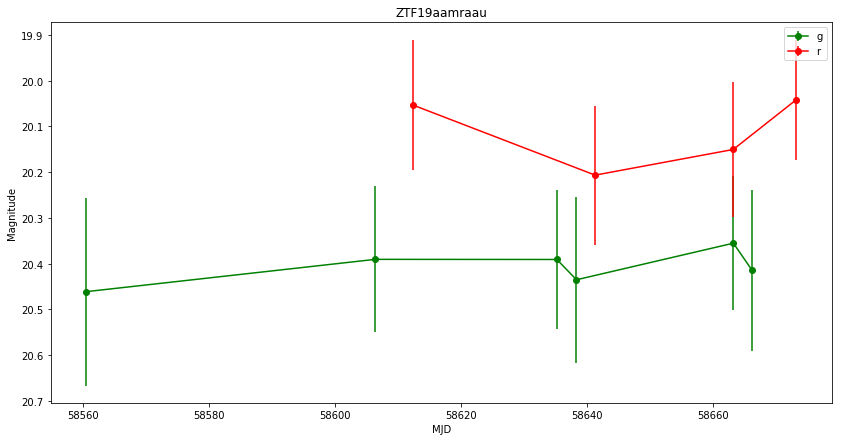

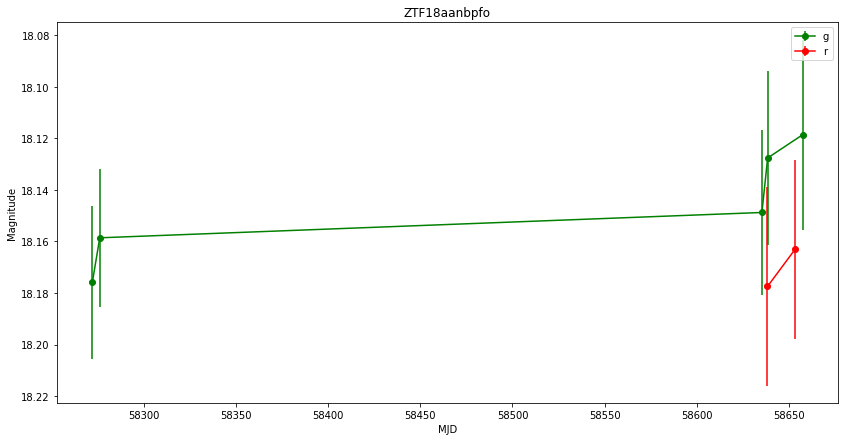

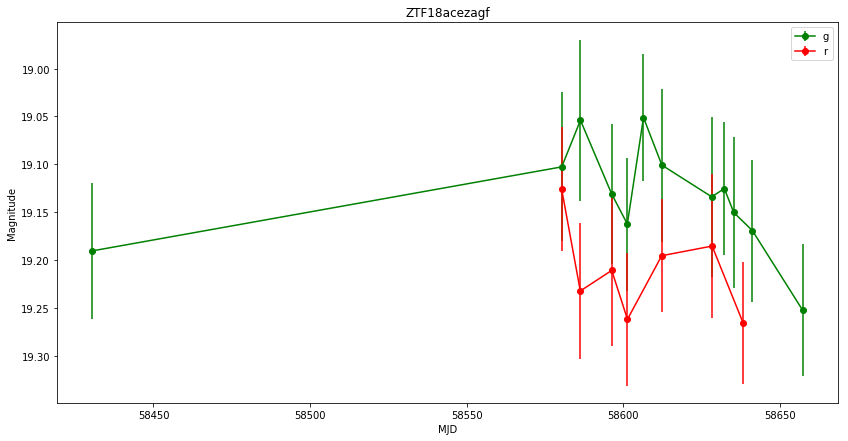

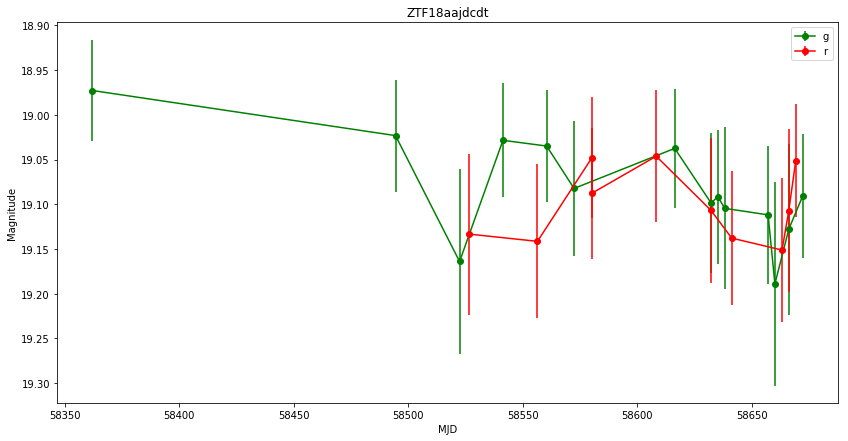

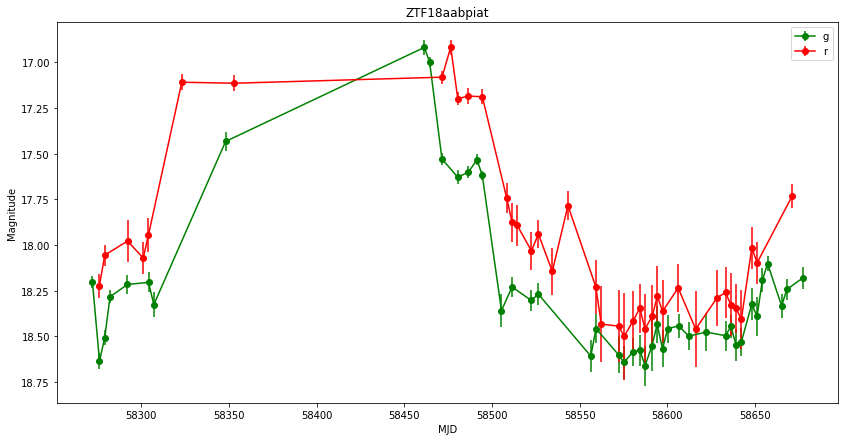

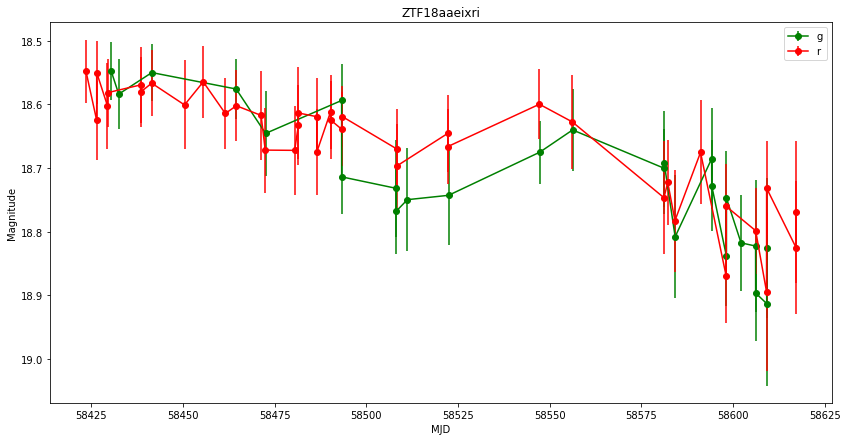

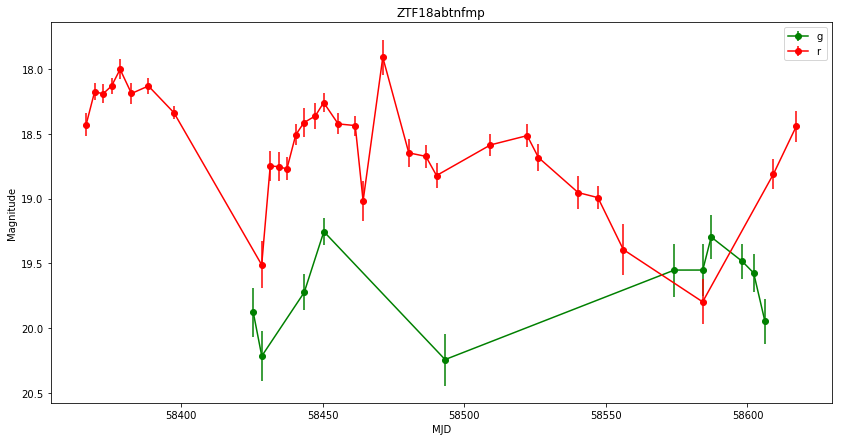

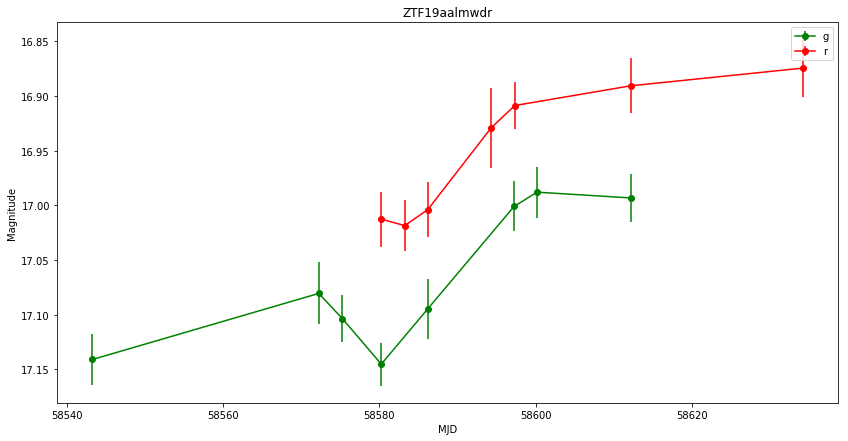

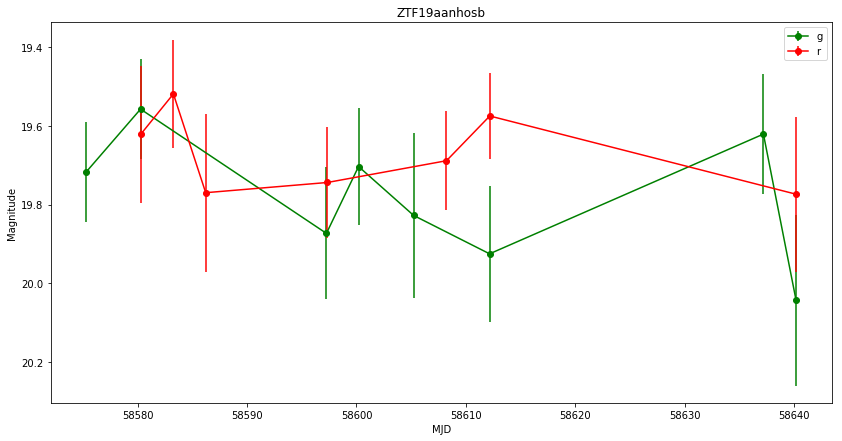

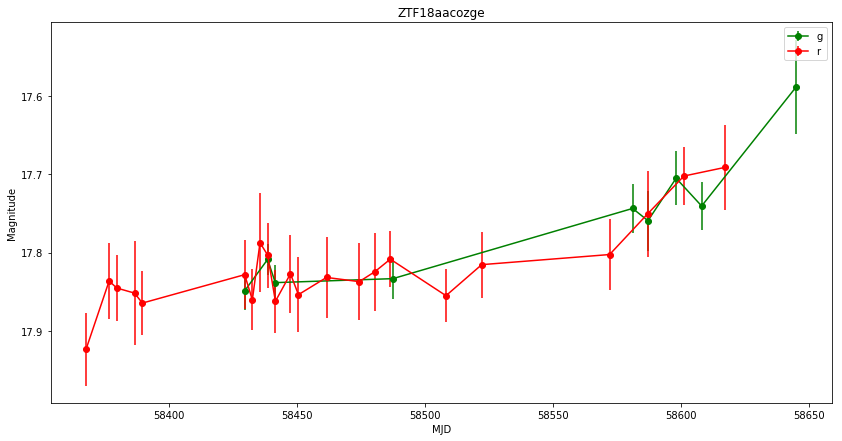

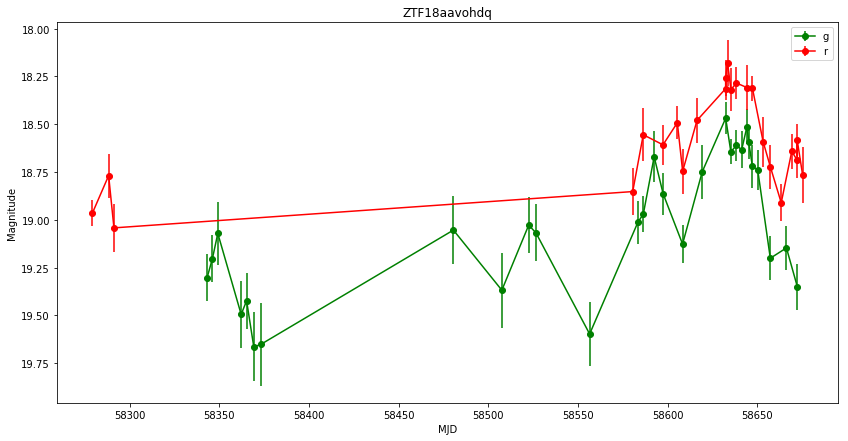

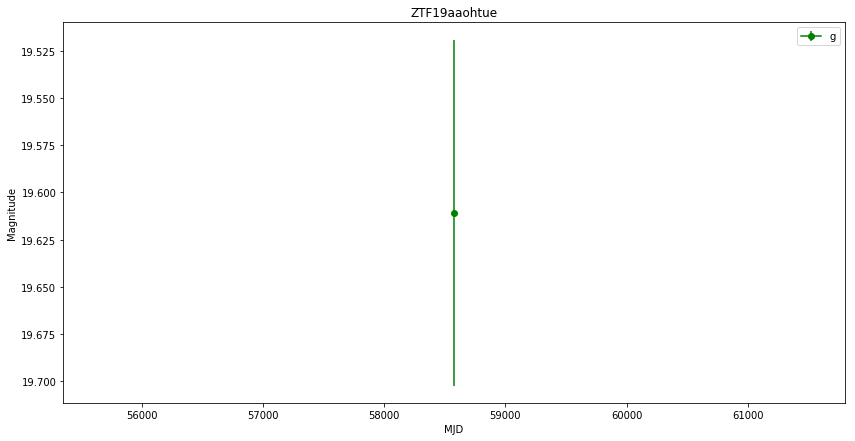

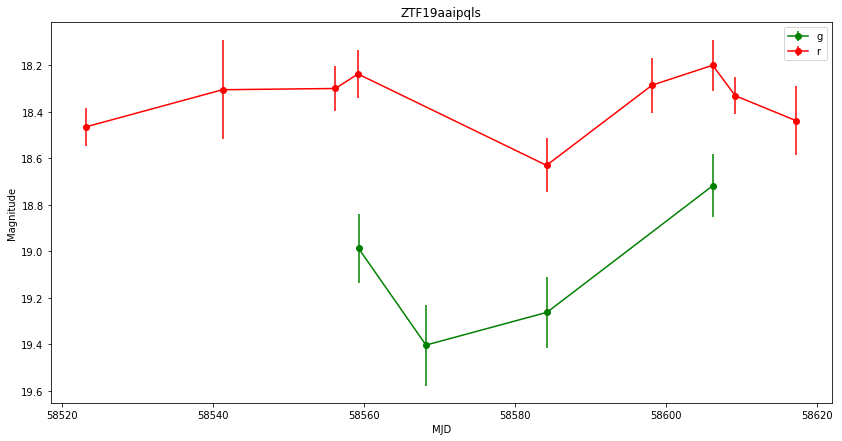

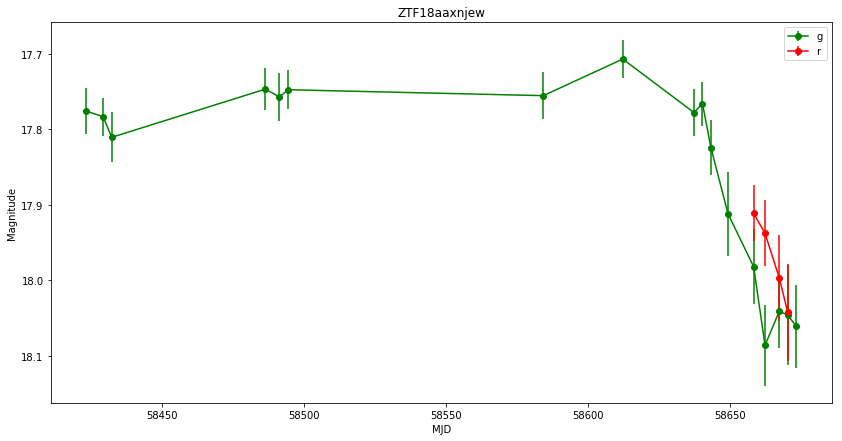

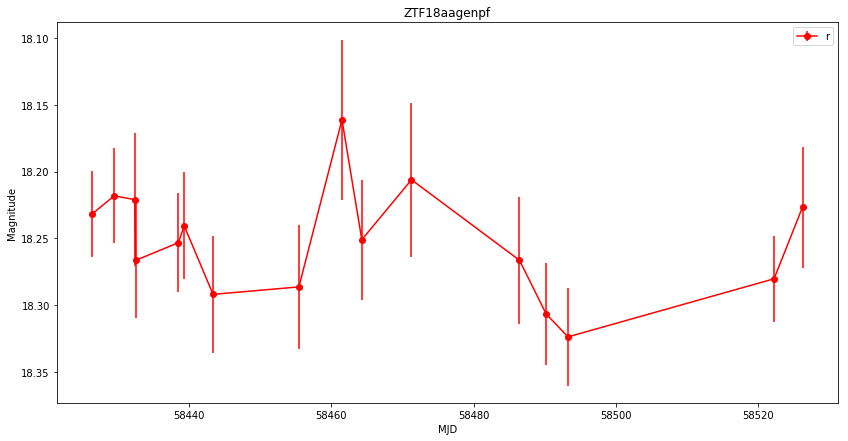

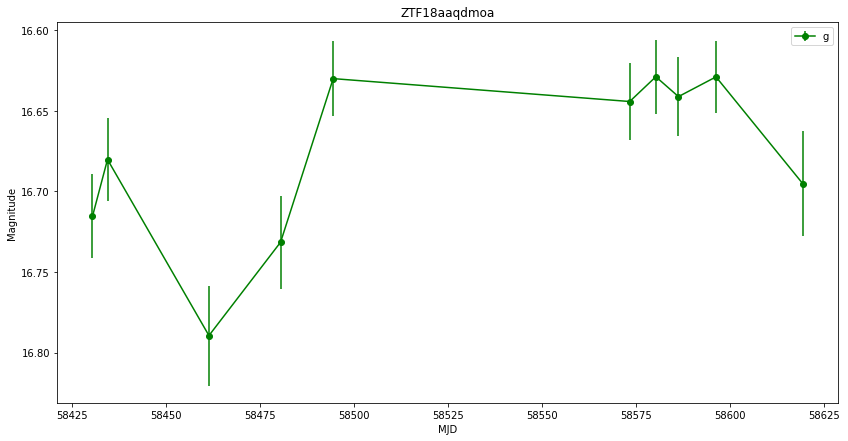

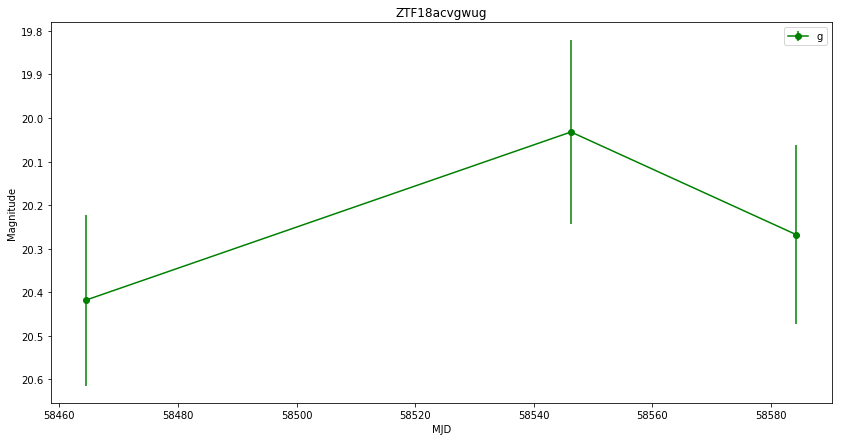

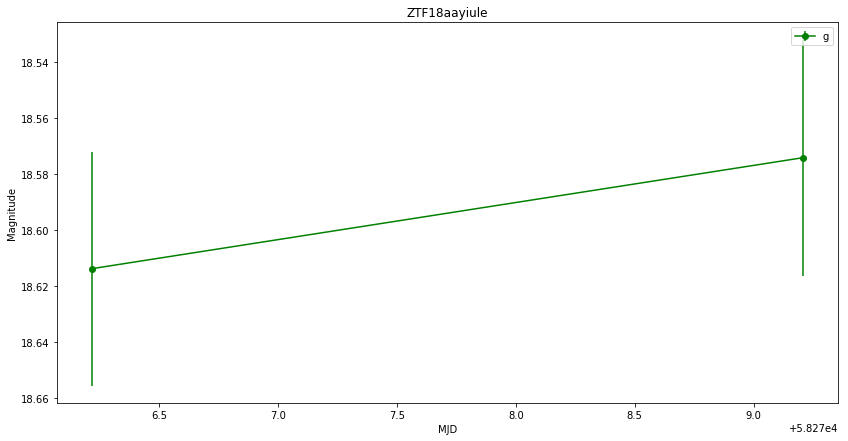

In [16]:
oids = xmatch['ZTF_oid'].values

print(oids, "\n")

for oid in oids:
        
    AGN_det, AGN_nondet = getAGNdata(oid, doplot = True)
    
    AGN_det_g = AGN_det[AGN_det['fid']==1]
    AGN_det_r = AGN_det[AGN_det['fid']==2]
    
    # compute and print features# g band, Pvar amd exvar
    if len(AGN_det_g.mjd)>=10:
        
        p_var_g, ex_var_g = var_parameters(AGN_det_g.mjd, AGN_det_g.magpsf_corr, AGN_det_g.sigmapsf_corr)
        print(oid," Pvar_g, exvar_g = ", p_var_g, ex_var_g)

        sigma_g, tau_g = GP_DRW(AGN_det_g.mjd, AGN_det_g.magpsf_corr, AGN_det_g.sigmapsf_corr)
        print(oid," sigma_g, tau_g = ", sigma_g, tau_g)
    
    if len(AGN_det_r.mjd)>=10:
        p_var_r, ex_var_r = var_parameters(AGN_det_r.mjd, AGN_det_r.magpsf_corr, AGN_det_r.sigmapsf_corr)
        print(oid," Pvar_r, exvar_r = ", p_var_r, ex_var_r)
    
        sigma_r, tau_r = GP_DRW(AGN_det_r.mjd, AGN_det_r.magpsf_corr, AGN_det_r.sigmapsf_corr)
        print(oid," sigma_r, tau_r = ", sigma_r, tau_r)
    